# Potholes

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os # Import the os module

# Get the current working directory
current_working_directory = os.getcwd()
print(f"Current Working Directory: {current_working_directory}")

# Construct paths relative to the parent directory where Data folder resides
# Go up one level (..) and then into the Data folder
pothole_cases_path = os.path.join(current_working_directory, '..', 'Data', '311_Pothole_Cases_18_24.csv')
pavement_path = os.path.join(current_working_directory, '..', 'Data', 'COSA_Pavement.csv')

# Normalize the paths to handle '..' correctly
pothole_cases_path = os.path.abspath(pothole_cases_path)
pavement_path = os.path.abspath(pavement_path)

# Print the resolved paths to confirm they are correct
print(f"Attempting to load Pothole Cases from: {pothole_cases_path}")
print(f"Attempting to load Pavement from: {pavement_path}")


# Load the datasets with explicit path checks
pothole_cases_df = pd.DataFrame() # Initialize as empty
pavement_latlon_df = pd.DataFrame() # Initialize as empty

# --- Load 311_Pothole_Cases_18_24.csv ---
if os.path.exists(pothole_cases_path):
    try:
        pothole_cases_df = pd.read_csv(pothole_cases_path)
        print(f"Successfully loaded {os.path.basename(pothole_cases_path)}")
    except Exception as e: # Catch a broader exception to see if it's not just FileNotFoundError
        print(f"Error reading {os.path.basename(pothole_cases_path)}: {e}")
else:
    print(f"File not found at: {pothole_cases_path}")

# --- Load COSA_Pavement.csv ---
if os.path.exists(pavement_path):
    try:
        pavement_latlon_df = pd.read_csv(pavement_path)
        print(f"Successfully loaded {os.path.basename(pothole_cases_path)}")
    except Exception as e: # Catch a broader exception
        print(f"Error reading {os.path.basename(pavement_path)}: {e}")
else:
    print(f"File not found at: {pavement_path}")


# --- Common Data Cleaning for Pothole Cases DataFrame ---
if not pothole_cases_df.empty:
    pothole_cases_df['OpenDate'] = pd.to_datetime(pothole_cases_df['OpenDate'])
    print("\nPothole Cases DataFrame head after date conversion:")
    print(pothole_cases_df.head())
else:
    print("\nPothole Cases DataFrame is empty or failed to load, skipping date conversion.")

# --- Common Data Cleaning for Pavement DataFrame (now using COSA_Pavement.csv) ---
if not pavement_latlon_df.empty:
    # Extract latitude and longitude from the 'GoogleMapView' column
    def extract_lat_lon(url):
        if pd.isna(url) or url == 'Not Available': # Also handle 'Not Available' string
            return None, None
        # The regex needs to be adapted for different URL formats if they exist.
        # Based on previous grep, 'place/29.58229225N 098.42891563W' is the format.
        match = re.search(r'place/(-?\d+\.?\d*)[N|S]\s*(-?\d+\.?\d*)[E|W]', url)
        if match:
            lat = float(match.group(1))
            lon = float(match.group(2))
            # Adjust longitude sign if it's West (W)
            if 'W' in match.group(2):
                lon = -abs(lon)
            return lat, lon
        return None, None

    # Apply the function to the 'GoogleMapView' column
    pavement_latlon_df[['Latitude', 'Longitude']] = pavement_latlon_df['GoogleMapView'].apply(
        lambda x: pd.Series(extract_lat_lon(x))
    )

    # It appears MSAG_Name is already a good street name representation.
    # We'll drop rows where MSAG_Name, Latitude, or Longitude are missing.
    pavement_latlon_df.dropna(subset=['MSAG_Name', 'Latitude', 'Longitude'], inplace=True)

    print("\nPavement DataFrame head (with Latitude and Longitude after cleaning):")
    print(pavement_latlon_df.head())
else:
    print("\nPavement DataFrame is empty or failed to load, skipping cleaning for lat/lon and MSAG_Name.")

print("\nData loading and initial cleaning attempts complete.")

Current Working Directory: c:\Users\HP\Desktop\BFI\BFI Potholes\PotHole_Project-main\visualizations
Attempting to load Pothole Cases from: c:\Users\HP\Desktop\BFI\BFI Potholes\PotHole_Project-main\Data\311_Pothole_Cases_18_24.csv
Attempting to load Pavement from: c:\Users\HP\Desktop\BFI\BFI Potholes\PotHole_Project-main\Data\COSA_Pavement.csv
Successfully loaded 311_Pothole_Cases_18_24.csv
Successfully loaded 311_Pothole_Cases_18_24.csv

Pothole Cases DataFrame head after date conversion:
    OpenDate  cases  WEEK1TAVG  WEEK2TAVG  WEEK1TDIF  WEEK2TDIF  WEEK1PRCP  \
0 2018-10-01     65       76.4       78.0  16.000000  14.120000   0.295692   
1 2018-10-02     75       76.3       78.0  15.861333  13.441333   0.278533   
2 2018-10-03     85       75.7       78.0  15.508235  13.448235   0.312353   
3 2018-10-04     72       75.6       78.0  14.700000  14.430556   0.470972   
4 2018-10-05     53       76.7       76.9  14.600000  14.800000   0.565660   

   WEEK3TAVG  WEEK4TAVG  WEEK2PRCP  W


--- Analysis for 'Will I face potholes on the way to ['E HOUSTON ST', 'S PINTO ST', 'BULVERDE RD', 'LA CANTERA PKWY']?' ---
Average Pavement Condition Index (PCI) in the specified area: 79.85
Prediction: Low likelihood of facing potholes due to generally good pavement conditions.


C:\Users\HP\AppData\Local\Temp\ipykernel_9888\1794041360.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MSAG_Name', y='PCI', data=area_pavement_data, palette='viridis')


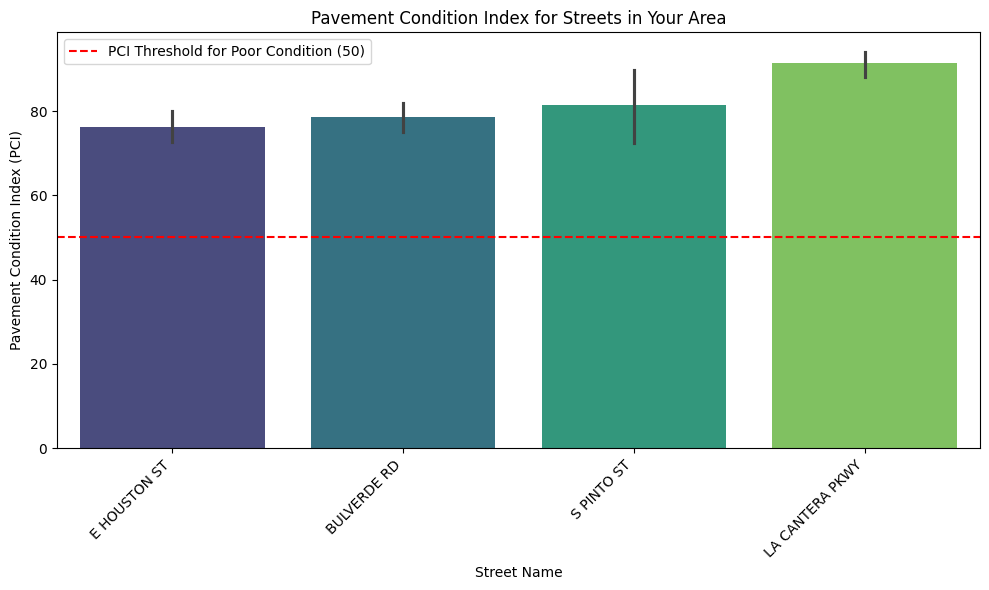


--- Visualization: Distribution of Pavement Condition Index (PCI) Across All Streets ---


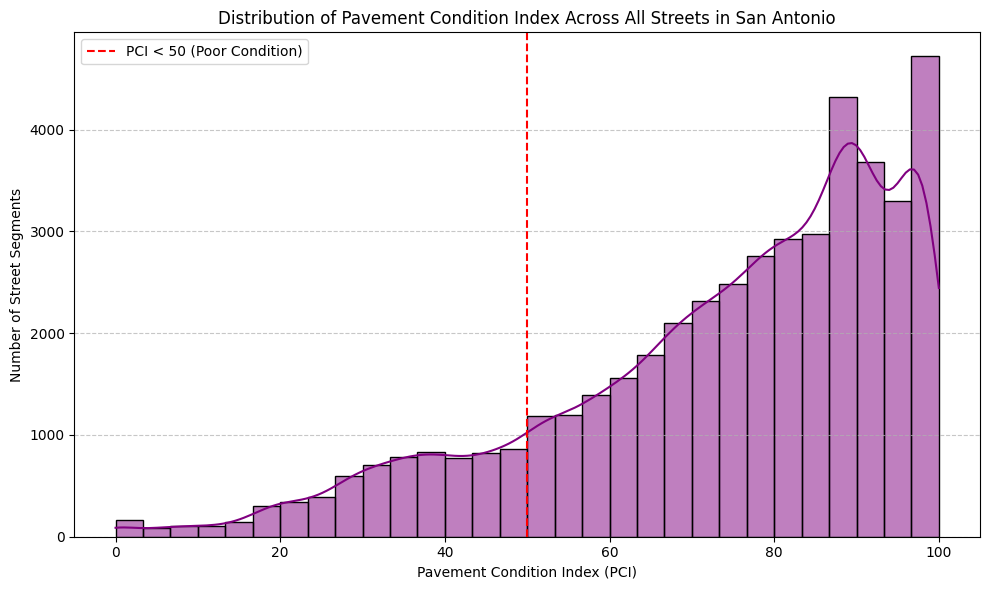


This histogram shows how many street segments fall into different PCI ranges.
Lower PCI values indicate poorer pavement conditions, and thus a higher likelihood of potholes.
The red dashed line at PCI 50 highlights segments typically considered in poor condition.


In [11]:
# --- Question 1: "Will I face potholes on the way to [area]?" ---
# This question is predictive and requires a defined 'area' and a way to link potholes to streets.
# Given the data, we'll use PCI as a proxy for pothole likelihood.
# We'll assume '[area]' can be specified by a list of street names for demonstration.

# IMPORTANT: Replace ['E HOUSTON ST', 'S PINTO ST'] with the actual street names you want to check for.
# You could also develop a more complex logic to define an 'area' based on coordinates.
target_area_streets = ['E HOUSTON ST', 'S PINTO ST', 'BULVERDE RD', 'LA CANTERA PKWY'] # Example streets

# Filter the pavement data for these streets
area_pavement_data = pavement_latlon_df[
    pavement_latlon_df['MSAG_Name'].isin(target_area_streets)
].copy() # .copy() to avoid SettingWithCopyWarning

if not area_pavement_data.empty:
    # Calculate average PCI for the target area
    avg_pci = area_pavement_data['PCI'].mean()

    print(f"\n--- Analysis for 'Will I face potholes on the way to {target_area_streets}?' ---")
    print(f"Average Pavement Condition Index (PCI) in the specified area: {avg_pci:.2f}")

    if avg_pci < 50: # Assuming PCI < 50 indicates poor condition / high pothole likelihood
        prediction = "High likelihood of facing potholes due to generally poor pavement conditions."
    elif avg_pci < 70:
        prediction = "Moderate likelihood of facing potholes due to fair pavement conditions."
    else:
        prediction = "Low likelihood of facing potholes due to generally good pavement conditions."

    print(f"Prediction: {prediction}")

    # Visualization: Bar plot of PCI for streets in the area
    plt.figure(figsize=(10, 6))
    sns.barplot(x='MSAG_Name', y='PCI', data=area_pavement_data, palette='viridis')
    plt.axhline(y=50, color='r', linestyle='--', label='PCI Threshold for Poor Condition (50)')
    plt.xlabel('Street Name')
    plt.ylabel('Pavement Condition Index (PCI)')
    plt.title(f'Pavement Condition Index for Streets in Your Area')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    print(f"\n--- Analysis for 'Will I face potholes on the way to {target_area_streets}?' ---")
    print(f"No pavement data found for the specified streets: {', '.join(target_area_streets)}. Please check street names or expand the search area.")


import matplotlib.pyplot as plt
import seaborn as sns

# Ensure pavement_latlon_df is loaded and cleaned from your earlier steps.

if not pavement_latlon_df.empty:
    print("\n--- Visualization: Distribution of Pavement Condition Index (PCI) Across All Streets ---")

    plt.figure(figsize=(10, 6))
    sns.histplot(pavement_latlon_df['PCI'], bins=30, kde=True, color='purple')
    plt.xlabel('Pavement Condition Index (PCI)')
    plt.ylabel('Number of Street Segments')
    plt.title('Distribution of Pavement Condition Index Across All Streets in San Antonio')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.axvline(x=50, color='r', linestyle='--', label='PCI < 50 (Poor Condition)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("\nThis histogram shows how many street segments fall into different PCI ranges.")
    print("Lower PCI values indicate poorer pavement conditions, and thus a higher likelihood of potholes.")
    print("The red dashed line at PCI 50 highlights segments typically considered in poor condition.")
else:
    print("\nPavement DataFrame is empty, cannot generate PCI distribution histogram.")




--- Let's find out: Should you avoid certain areas because of potholes? ---
We'll look at the 'Pavement Condition Index' (PCI) for different parts of San Antonio.
Think of PCI as a report card for roads: a *lower* score means the road is in *worse* shape and likely has more potholes.

Here are the average road condition scores (PCI) for different districts:
(Remember: Lower score = worse roads)
District
2_3     54.523953
5_7     54.835000
1_7     58.847447
4_5     58.896000
3_5     65.161774
3_4     67.138857
1_2     67.293077
2_10    67.434366
1       68.794510
1_10    68.817727
2       68.854020
5_6     68.956667
3       70.555400
5       71.900784
1_8     72.675000
1_9     73.276207
10      73.844363
7       74.274261
4       74.355901
7_8     76.460000
2_5     77.330000
1_5     78.124082
8_9     78.410000
4_6     79.514941
6       79.564295
9       80.850087
9_10    81.197451
8       82.115183
0       82.138333
6_7     84.810971
Name: PCI, dtype: float64

Recommendation: You might

C:\Users\HP\AppData\Local\Temp\ipykernel_9888\3892517467.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=district_pci.index, y=district_pci.values, palette='viridis')


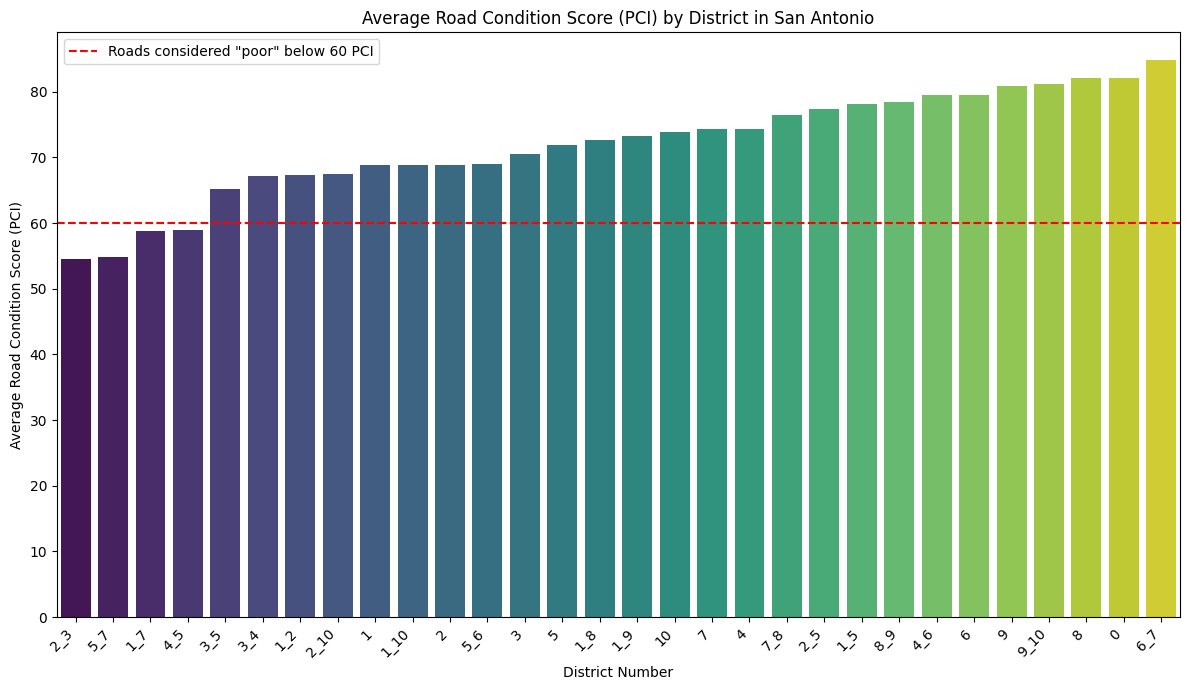


What this graph shows:
- Each bar is a district, and its height shows the average road condition score (PCI).
- Lower bars mean worse roads.
- The red dashed line is our 'avoidance' line. Districts with bars below this line (PCI less than 60) are areas where roads are in poorer shape.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure pavement_latlon_df is loaded and cleaned from your earlier steps.

# --- Question: "Should I avoid [area] because of the potholes?" (Improved District Understanding) ---

if not pavement_latlon_df.empty:
    print("\n--- Let's find out: Should you avoid certain areas because of potholes? ---")
    print("We'll look at the 'Pavement Condition Index' (PCI) for different parts of San Antonio.")
    print("Think of PCI as a report card for roads: a *lower* score means the road is in *worse* shape and likely has more potholes.")

    if 'District' in pavement_latlon_df.columns:
        # Group by District (number) and calculate the average PCI
        district_pci = pavement_latlon_df.groupby('District')['PCI'].mean().sort_values()

        print("\nHere are the average road condition scores (PCI) for different **District Numbers**:")
        print("(Remember: Lower score = worse roads)")
        print(district_pci)

        # Define a simple threshold for "avoidance" (e.g., average PCI below 60 is considered poor)
        avoid_threshold = 60
        avoid_districts = district_pci[district_pci < avoid_threshold].index.tolist()

        if avoid_districts:
            print(f"\nRecommendation: Based on average PCI, consider avoiding these **District Numbers** due to generally poorer pavement conditions (PCI below {avoid_threshold}):")
            print(f"**District Numbers** to potentially avoid: {', '.join(map(str, avoid_districts))}")
        else:
            print(f"\nRecommendation: All **District Numbers** seem to have an average road condition score above {avoid_threshold}. No specific districts are highlighted for avoidance based on this criteria.")

        # Visualization: Bar plot of average PCI by District Number
        plt.figure(figsize=(12, 7))
        # Ensure district numbers are treated as categorical for correct plotting if they aren't already
        sns.barplot(x=district_pci.index.astype(str), y=district_pci.values, palette='viridis')
        plt.axhline(y=avoid_threshold, color='r', linestyle='--', label=f'Roads considered "poor" below {avoid_threshold} PCI')
        plt.xlabel('District Number') # Clearly label as District Number
        plt.ylabel('Average Road Condition Score (PCI)')
        plt.title('Average Road Condition Score (PCI) by District Number in San Antonio')
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()

        print("\nWhat this graph shows:")
        print("- Each bar represents a **District Number**, and its height shows the average road condition score (PCI).")
        print("- Lower bars mean worse roads.")
        print(f"- The red dashed line is our 'avoidance' line. **District Numbers** with bars below this line (PCI less than {avoid_threshold}) are areas where roads are in poorer shape.")

    else:
        print("We couldn't group by 'District' for a broader area view, so we'll show you the specific streets with the worst road conditions instead.")
        # Fallback to street-level if district not available:
        street_pci = pavement_latlon_df.groupby('MSAG_Name')['PCI'].mean().sort_values(ascending=True).head(10) # Top 10 streets with lowest PCI

        print("\nHere are the Top 10 streets with the lowest average road condition scores (PCI):")
        print("These streets are more likely to have significant potholes and might be worth avoiding:")
        print(street_pci)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=street_pci.index, y=street_pci.values, palette='plasma')
        avoid_threshold = 60 # Using the same threshold for consistency
        plt.axhline(y=avoid_threshold, color='r', linestyle='--', label=f'Roads considered "poor" below {avoid_threshold} PCI')
        plt.xlabel('Street Name')
        plt.ylabel('Average Road Condition Score (PCI)')
        plt.title('Top 10 Streets with Worst Road Conditions (Potential Avoidance)')
        plt.xticks(rotation=45, ha='right')
        plt.legend()
        plt.tight_layout()
        plt.show()

        print("\nWhat this graph shows:")
        print("- These are the streets where the roads are in the worst condition, based on their average PCI score.")
        print("- Shorter bars mean worse roads, indicating a higher chance of potholes.")
        print(f"- The red dashed line helps highlight roads with a PCI score below {avoid_threshold}, which are generally considered poor.")

else:
    print("\nSorry, we don't have road condition data to answer 'Should I avoid [area] because of the potholes?'")
    print("Please make sure the pavement data is loaded correctly.")


--- Let's find out: How many potholes have been reported each month? ---

In **June 2024**, a total of **43 potholes** were reported.

Here's a look at the number of potholes reported month-by-month over time:


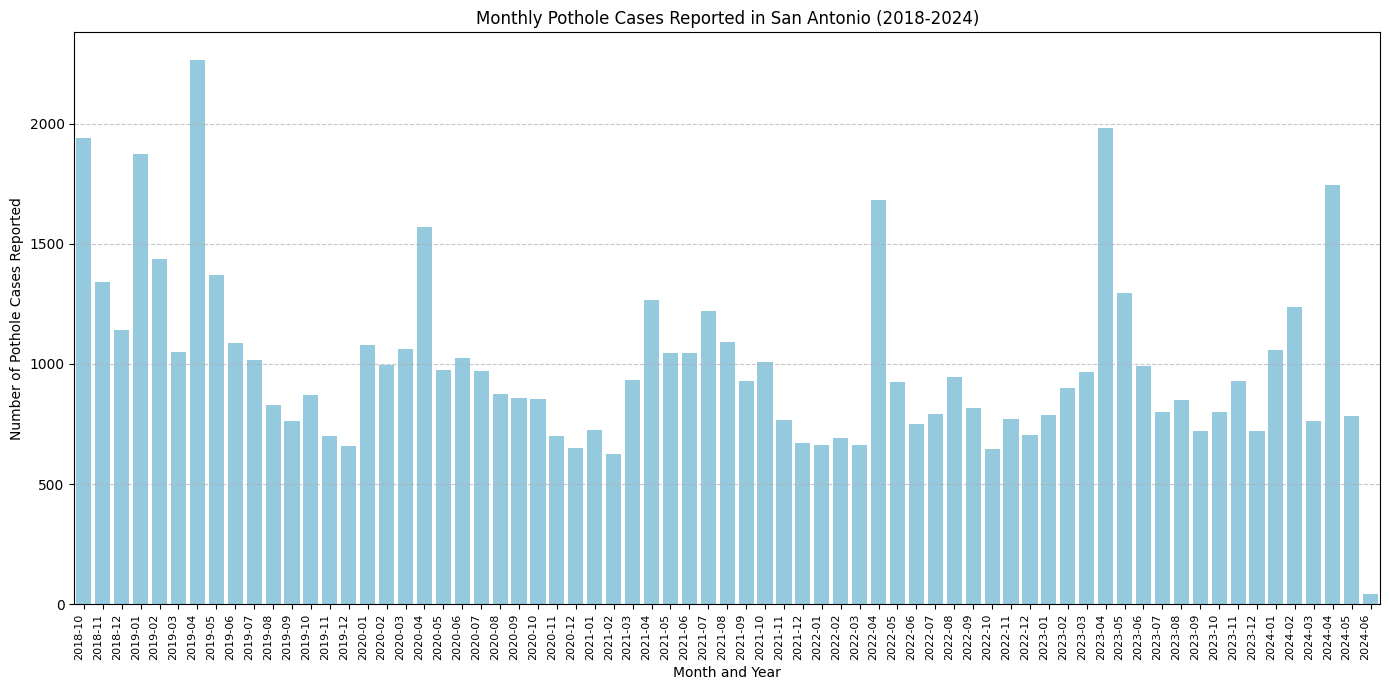


What this graph shows:
- Each bar represents a month and year.
- The height of the bar tells you the total number of potholes reported in that month.
- This helps you see trends, like which months or seasons have more potholes reported.


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure pothole_cases_df is loaded and cleaned from your earlier steps.

# --- Question: "How many potholes have been found this month?" ---
# This uses the 311 pothole cases data to show monthly trends.

if not pothole_cases_df.empty:
    # Ensure 'OpenDate' is datetime (this should be done in your common cleaning)
    # Create a 'YearMonth' column to group cases by month and year
    pothole_cases_df['YearMonth'] = pothole_cases_df['OpenDate'].dt.to_period('M')

    # Group by month and sum the number of reported cases
    monthly_potholes = pothole_cases_df.groupby('YearMonth')['cases'].sum().sort_index()

    print("\n--- Let's find out: How many potholes have been reported each month? ---")

    if not monthly_potholes.empty:
        # Get the data for the most recent month available in your dataset
        latest_month_period = monthly_potholes.index.max()
        potholes_this_month = monthly_potholes.loc[latest_month_period]

        # Format the month for a user-friendly display
        latest_month_str = latest_month_period.strftime('%B %Y')

        print(f"\nIn **{latest_month_str}**, a total of **{potholes_this_month} potholes** were reported.")
        print("\nHere's a look at the number of potholes reported month-by-month over time:")

        # Visualization: Bar plot of potholes per month
        plt.figure(figsize=(14, 7))
        # Prepare data for plotting, converting YearMonth Period to string for x-axis labels
        monthly_potholes_plot_data = monthly_potholes.to_frame().reset_index()
        monthly_potholes_plot_data['YearMonthStr'] = monthly_potholes_plot_data['YearMonth'].dt.strftime('%Y-%m') # Format as YYYY-MM

        sns.barplot(x='YearMonthStr', y='cases', data=monthly_potholes_plot_data, color='skyblue')
        plt.xlabel('Month and Year')
        plt.ylabel('Number of Pothole Cases Reported')
        plt.title('Monthly Pothole Cases Reported in San Antonio (2018-2024)')
        plt.xticks(rotation=90, ha='right', fontsize=8) # Rotate labels for better readability
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

        print("\nWhat this graph shows:")
        print("- Each bar represents a month and year.")
        print("- The height of the bar tells you the total number of potholes reported in that month.")
        print("- This helps you see trends, like which months or seasons have more potholes reported.")
    else:
        print("No monthly pothole cases data available to show trends.")
else:
    print("\nSorry, the Pothole Cases DataFrame is empty or failed to load.")
    print("Cannot answer 'How many potholes have been found this month?'.")



--- Let's find out: Which streets have the worst potholes (poorest road conditions)? ---
We'll calculate a 'Road Deterioration Score' for each street.
This score is 100 minus the Pavement Condition Index (PCI).
A **HIGHER DETERIORATION SCORE** means the road is in **WORSE SHAPE** and more prone to potholes.

Here are the **Top 10 streets with the worst road conditions**:
These streets are most likely to have significant potholes and are listed from worst to less worst:
1. CADMUS
2. UNNAMED PARK RD AT N ST MARYS
3. W TERMINAL
4. DEE HOWARD WAY
5. BRAZIL
6. W QUINCY
7. ALPINE
8. JOHN HUTH
9. Dick Friedrich
10. SIDNEY BROOKS


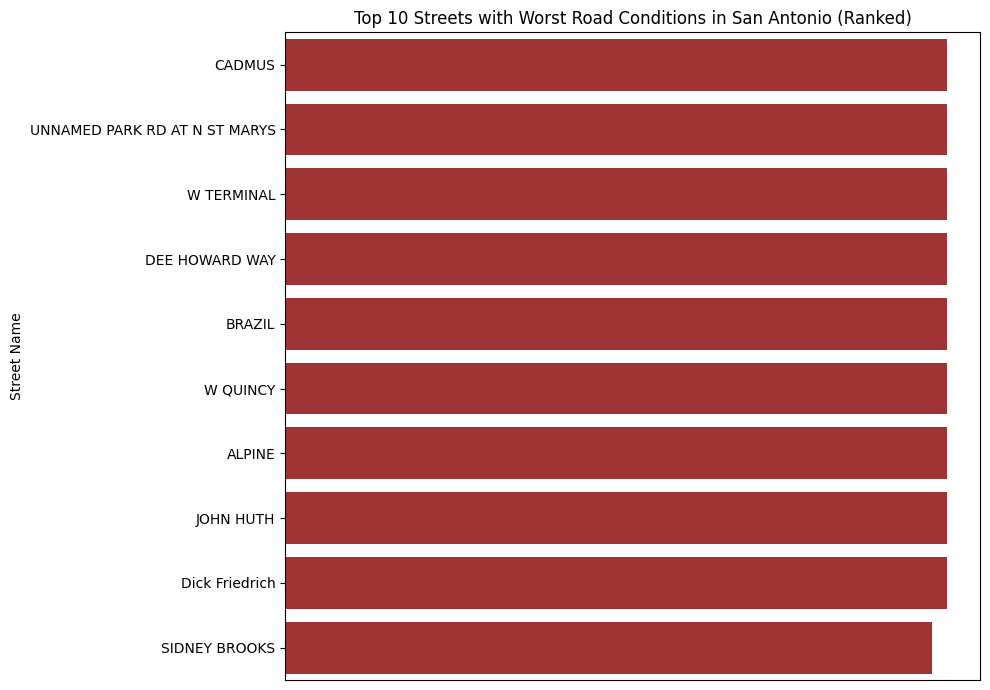


What this graph shows:
- This graph visually ranks the 10 streets with the worst road conditions.
- **The streets are ordered from top (worst) to bottom (less worst).**
- You can see the name of each street on the left side.
- The length of the red bar helps you visually compare how much worse each street is compared to others on this list, even without seeing the numerical score.
- This helps pinpoint specific areas that might need immediate attention or where drivers should be cautious.


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure pavement_latlon_df is loaded and cleaned from your earlier steps.

# --- Question: "Display streets with the worst potholes" (Visualizing Names Only) ---
# We're transforming PCI into a "Road Deterioration Score" (100 - PCI).
# A HIGHER Deterioration Score means a WORSE road and more potholes.
# The graph will show street names ranked by this score, but without showing the score numbers on the axis.

if not pavement_latlon_df.empty:
    print("\n--- Let's find out: Which streets have the worst potholes (poorest road conditions)? ---")
    print("We'll calculate a 'Road Deterioration Score' for each street.")
    print("This score is 100 minus the Pavement Condition Index (PCI).")
    print("A **HIGHER DETERIORATION SCORE** means the road is in **WORSE SHAPE** and more prone to potholes.")

    # Calculate the average PCI for each unique street (MSAG_Name)
    street_pci_avg = pavement_latlon_df.groupby('MSAG_Name')['PCI'].mean()

    if not street_pci_avg.empty:
        # Calculate the Road Deterioration Score
        street_deterioration_score = 100 - street_pci_avg
        # Sort in descending order to get the worst roads (highest deterioration scores) at the top
        top_worst_streets_data = street_deterioration_score.sort_values(ascending=False).head(10)

        print("\nHere are the **Top 10 streets with the worst road conditions**:")
        print("These streets are most likely to have significant potholes and are listed from worst to less worst:")
        # Just print the names in a ranked list for clarity in the text output
        for rank, (street_name, score) in enumerate(top_worst_streets_data.items()):
            print(f"{rank + 1}. {street_name}")

        # Visualization: Horizontal Bar plot of top 10 worst streets
        plt.figure(figsize=(10, 7))
        sns.barplot(x=top_worst_streets_data.values, y=top_worst_streets_data.index, color='firebrick')

        # --- IMPORTANT: Remove X-axis labels, ticks, and the x-axis title ---
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.xlabel('') # Remove x-axis label
        plt.title('Top 10 Streets with Worst Road Conditions in San Antonio (Ranked)')
        plt.ylabel('Street Name')
        plt.tight_layout() # Adjust layout to prevent labels from overlapping
        plt.show()

        print("\nWhat this graph shows:")
        print("- This graph visually ranks the 10 streets with the worst road conditions.")
        print("- **The streets are ordered from top (worst) to bottom (less worst).**")
        print("- You can see the name of each street on the left side.")
        print("- The length of the red bar helps you visually compare how much worse each street is compared to others on this list, even without seeing the numerical score.")
        print("- This helps pinpoint specific areas that might need immediate attention or where drivers should be cautious.")
    else:
        print("No street-level road condition data available to identify worst streets.")
else:
    print("\nSorry, the Pavement DataFrame is empty or failed to load.")
    print("Cannot answer 'Display streets with the worst potholes'.")

# Safety & Prevention


--- Let's find the top 10 most frequently reported complaint locations (streets) ---
We'll analyze the 'COSA_pavement_311.csv' file to see which streets have the most service requests of any type.
Successfully loaded COSA_pavement_311.csv for complaint location analysis.

Here are the **Top 10 most frequently reported complaint locations (streets)**:
1. CULEBRA RD: 158 total reports
2. VANCE JACKSON: 149 total reports
3. S ZARZAMORA: 136 total reports
4. BABCOCK RD: 136 total reports
5. S FLORES ST: 133 total reports
6. HUEBNER RD: 128 total reports
7. W COMMERCE ST: 120 total reports
8. N NEW BRAUNFELS AVE: 117 total reports
9. McCullough Ave: 115 total reports
10. SAN PEDRO AVE: 114 total reports


C:\Users\HP\AppData\Local\Temp\ipykernel_9888\1446846171.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_complaint_locations.values, y=top_10_complaint_locations.index, palette='crest') # Using 'crest' palette


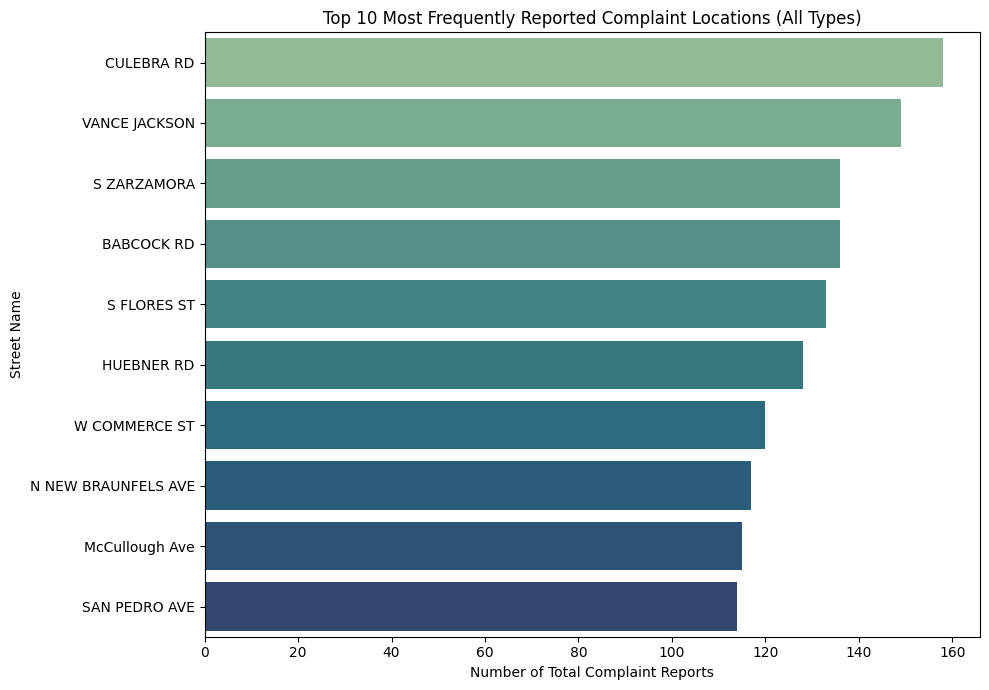


What this graph shows:
- Each bar represents a street where various types of complaints have been reported.
- The longer the bar, the more total complaints (potholes, missed trash, etc.) have been reported on that street.
- This helps identify streets that are hotspots for overall service requests, not just potholes.


In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Get the current working directory to correctly form paths
current_working_directory = os.getcwd()
cosa_pavement_311_path = os.path.abspath(os.path.join(current_working_directory, '..', 'Data', 'COSA_pavement_311.csv'))

# --- Question: "What are the top 10 most frequently reported complain locations?" ---
print("\n--- Let's find the top 10 most frequently reported complaint locations (streets) ---")
print("We'll analyze the 'COSA_pavement_311.csv' file to see which streets have the most service requests of any type.")

# Load necessary columns: MSAG_Name (for location)
try:
    columns_to_load = ['MSAG_Name'] # Only need street name for this count
    df_cosa_pavement_311_complaints = pd.read_csv(cosa_pavement_311_path, usecols=columns_to_load)
    print(f"Successfully loaded {os.path.basename(cosa_pavement_311_path)} for complaint location analysis.")
except Exception as e:
    print(f"Error loading {os.path.basename(cosa_pavement_311_path)}: {e}")
    df_cosa_pavement_311_complaints = pd.DataFrame() # Initialize as empty

if not df_cosa_pavement_311_complaints.empty:
    # Drop rows where MSAG_Name (street name) is missing, as we need a location
    df_cosa_pavement_311_complaints.dropna(subset=['MSAG_Name'], inplace=True)

    if not df_cosa_pavement_311_complaints.empty:
        # Count the frequency of each location (MSAG_Name)
        # This will count all types of complaints associated with each street
        top_10_complaint_locations = df_cosa_pavement_311_complaints['MSAG_Name'].value_counts().head(10)

        print("\nHere are the **Top 10 most frequently reported complaint locations (streets)**:")
        # Print with rank and count
        for rank, (street_name, count) in enumerate(top_10_complaint_locations.items()):
            print(f"{rank + 1}. {street_name}: {count} total reports")

        # --- Visualize the top 10 locations ---
        plt.figure(figsize=(10, 7))
        # Horizontal bar chart for better readability of street names
        sns.barplot(x=top_10_complaint_locations.values, y=top_10_complaint_locations.index, palette='crest') # Using 'crest' palette
        plt.xlabel('Number of Total Complaint Reports')
        plt.ylabel('Street Name')
        plt.title('Top 10 Most Frequently Reported Complaint Locations (All Types)')
        plt.tight_layout()
        plt.show()

        print("\nWhat this graph shows:")
        print("- Each bar represents a street where various types of complaints have been reported.")
        print("- The longer the bar, the more total complaints (potholes, missed trash, etc.) have been reported on that street.")
        print("- This helps identify streets that are hotspots for overall service requests, not just potholes.")

    else:
        print("\nNo valid street names found in the COSA_pavement_311.csv after cleaning.")
else:
    print("\nError: COSA_pavement_311.csv could not be loaded or is empty.")
    print("Cannot determine top 10 complaint locations.")



--- Let's find out: How many complaints reported are still unresolved, broken down by year? ---
We'll analyze the 'COSA_pavement_311.csv' file to track complaint status over the years.
Successfully loaded COSA_pavement_311.csv for yearly analysis.

Complaint Status by Year:
   OpenedYear  TotalComplaints  UnresolvedComplaints
0        2022            21916                     0
1        2023            17867                     0
2        2024             7375                     0

Breakdown of complaints by status for each year:
Year 2022: Total = 21916, Unresolved = 0 (0.00%)
Year 2023: Total = 17867, Unresolved = 0 (0.00%)
Year 2024: Total = 7375, Unresolved = 0 (0.00%)


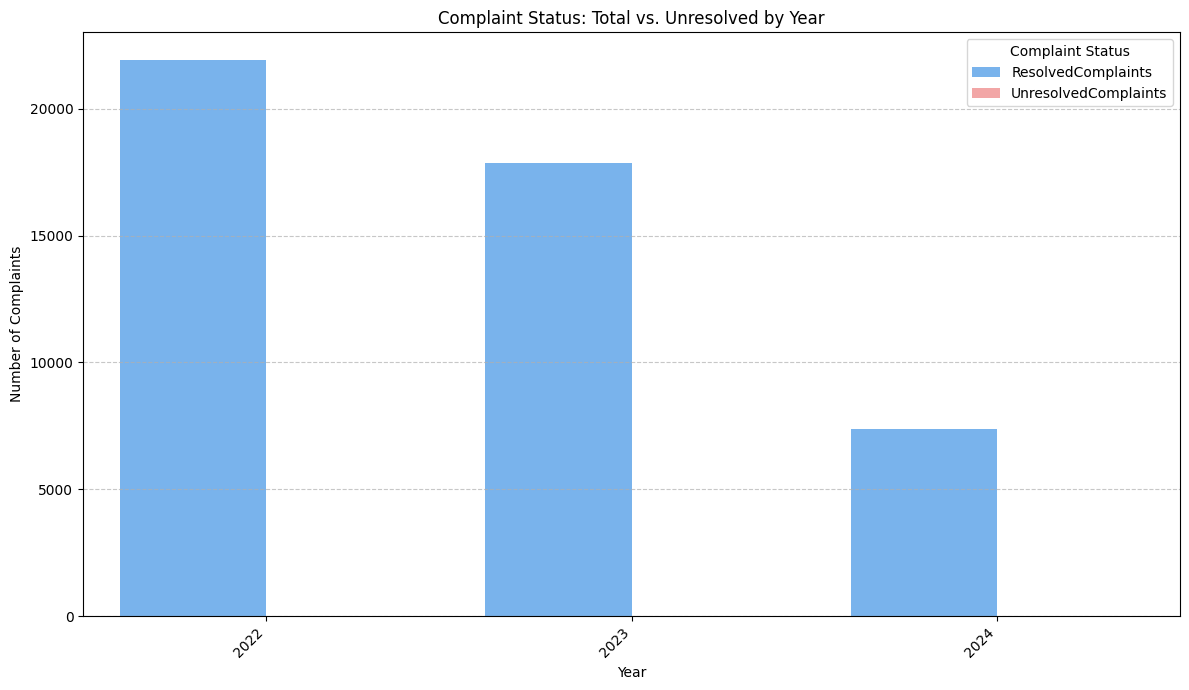


What this graph shows:
- Each bar represents a year, broken into two segments: 'Resolved Complaints' (blue) and 'Unresolved Complaints' (red).
- The total height of the bar shows the total number of complaints reported in that year.
- The red portion of each bar indicates how many complaints from that year are still open.
- This helps track the backlog of unresolved complaints over time and identify years with significant outstanding issues.


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Get the current working directory to correctly form paths
current_working_directory = os.getcwd()
cosa_pavement_311_path = os.path.abspath(os.path.join(current_working_directory, '..', 'Data', 'COSA_pavement_311.csv'))

# --- Question: "How many complaints reported are still unresolved (for each year)?" ---
print("\n--- Let's find out: How many complaints reported are still unresolved, broken down by year? ---")
print("We'll analyze the 'COSA_pavement_311.csv' file to track complaint status over the years.")

# Load necessary columns: OPENEDDATETIME, CLOSEDDATETIME
try:
    columns_to_load = ['OPENEDDATETIME', 'CLOSEDDATETIME']
    df_complaints_yearly = pd.read_csv(cosa_pavement_311_path, usecols=columns_to_load)
    print(f"Successfully loaded {os.path.basename(cosa_pavement_311_path)} for yearly analysis.")
except Exception as e:
    print(f"Error loading {os.path.basename(cosa_pavement_311_path)}: {e}")
    df_complaints_yearly = pd.DataFrame() # Initialize as empty

if not df_complaints_yearly.empty:
    # Convert date/time columns to datetime objects
    df_complaints_yearly['OPENEDDATETIME'] = pd.to_datetime(df_complaints_yearly['OPENEDDATETIME'], errors='coerce')
    df_complaints_yearly['CLOSEDDATETIME'] = pd.to_datetime(df_complaints_yearly['CLOSEDDATETIME'], errors='coerce')

    # Drop rows where OPENEDDATETIME is missing
    df_complaints_yearly.dropna(subset=['OPENEDDATETIME'], inplace=True)

    if not df_complaints_yearly.empty:
        # Extract the year from the opened date
        df_complaints_yearly['OpenedYear'] = df_complaints_yearly['OPENEDDATETIME'].dt.year

        # Determine unresolved status: CLOSEDDATETIME is NaT (Not a Time)
        df_complaints_yearly['IsUnresolved'] = df_complaints_yearly['CLOSEDDATETIME'].isna()

        # Group by OpenedYear and count total and unresolved complaints
        yearly_status = df_complaints_yearly.groupby('OpenedYear').agg(
            TotalComplaints=('OPENEDDATETIME', 'count'),
            UnresolvedComplaints=('IsUnresolved', 'sum')
        ).reset_index()

        # Convert 'UnresolvedComplaints' count to integer
        yearly_status['UnresolvedComplaints'] = yearly_status['UnresolvedComplaints'].astype(int)

        print("\nComplaint Status by Year:")
        print(yearly_status)

        # Calculate percentage unresolved for text output
        if not yearly_status.empty:
            yearly_status['ResolvedComplaints'] = yearly_status['TotalComplaints'] - yearly_status['UnresolvedComplaints']

            print("\nBreakdown of complaints by status for each year:")
            for index, row in yearly_status.iterrows():
                if row['TotalComplaints'] > 0:
                    percent_unresolved = (row['UnresolvedComplaints'] / row['TotalComplaints']) * 100
                    print(f"Year {int(row['OpenedYear'])}: Total = {int(row['TotalComplaints'])}, Unresolved = {int(row['UnresolvedComplaints'])} ({percent_unresolved:.2f}%)")
                else:
                    print(f"Year {int(row['OpenedYear'])}: No complaints reported.")

            # --- Visualization: Stacked Bar Chart of Total vs. Unresolved Complaints by Year ---
            plt.figure(figsize=(12, 7))
            yearly_status_melted = yearly_status.melt(id_vars='OpenedYear', value_vars=['ResolvedComplaints', 'UnresolvedComplaints'],
                                                      var_name='Status', value_name='Count')

            sns.barplot(
                x='OpenedYear',
                y='Count',
                hue='Status',
                data=yearly_status_melted,
                palette={'ResolvedComplaints': '#66b3ff', 'UnresolvedComplaints': '#ff9999'} # Blue for resolved, red for unresolved
            )
            plt.xlabel('Year')
            plt.ylabel('Number of Complaints')
            plt.title('Complaint Status: Total vs. Unresolved by Year')
            plt.xticks(rotation=45, ha='right')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.legend(title='Complaint Status')
            plt.tight_layout()
            plt.show()

            print("\nWhat this graph shows:")
            print("- Each bar represents a year, broken into two segments: 'Resolved Complaints' (blue) and 'Unresolved Complaints' (red).")
            print("- The total height of the bar shows the total number of complaints reported in that year.")
            print("- The red portion of each bar indicates how many complaints from that year are still open.")
            print("- This helps track the backlog of unresolved complaints over time and identify years with significant outstanding issues.")

        else:
            print("\nNo complaints found to summarize by year.")
    else:
        print("\nNo valid complaint data with opened dates found after initial cleaning.")
else:
    print("\nError: COSA_pavement_311.csv could not be loaded or is empty.")
    print("Cannot determine unresolved complaints by year.")


Attempting to load Pavement from: c:\Users\HP\Desktop\BFI\BFI Potholes\PotHole_Project-main\Data\COSA_Pavement.csv
Attempting to load Full Complaint Data from: c:\Users\HP\Desktop\BFI\BFI Potholes\PotHole_Project-main\Data\COSA_pavement_311.csv
Successfully loaded COSA_Pavement.csv
Successfully loaded COSA_pavement_311.csv

Full Complaint DataFrame head after date conversion:
   OBJECTID  CartID     MSAG_Name         FromStreet       ToStreet  \
0         1  307451    TRIPLE CRK        ELM PARK DR  TRAILWAY PARK   
1         2  308522     RIDGEBORO             SEARCY        TALCOTT   
2         3  207491      SHADWELL            COLLEEN      ZACHRY DR   
3         4  503790  E HOUSTON ST  IH 10 E ACCESS RD   NOBLEWOOD DR   
4         5  504320        MEBANE         S OLIVE ST   LINDA LOU DR   

  Jurisdiction District   LengthFeet InstallDate ProjectName  ...  TMinW23  \
0  San Antonio       10  1375.565913  1980-01-01     Unknown  ...    56.60   
1  San Antonio        9   307.522205  

C:\Users\HP\AppData\Local\Temp\ipykernel_9888\2012186687.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PCI', y='MSAG_Name', data=priority_deterioration_score, palette='YlOrRd')


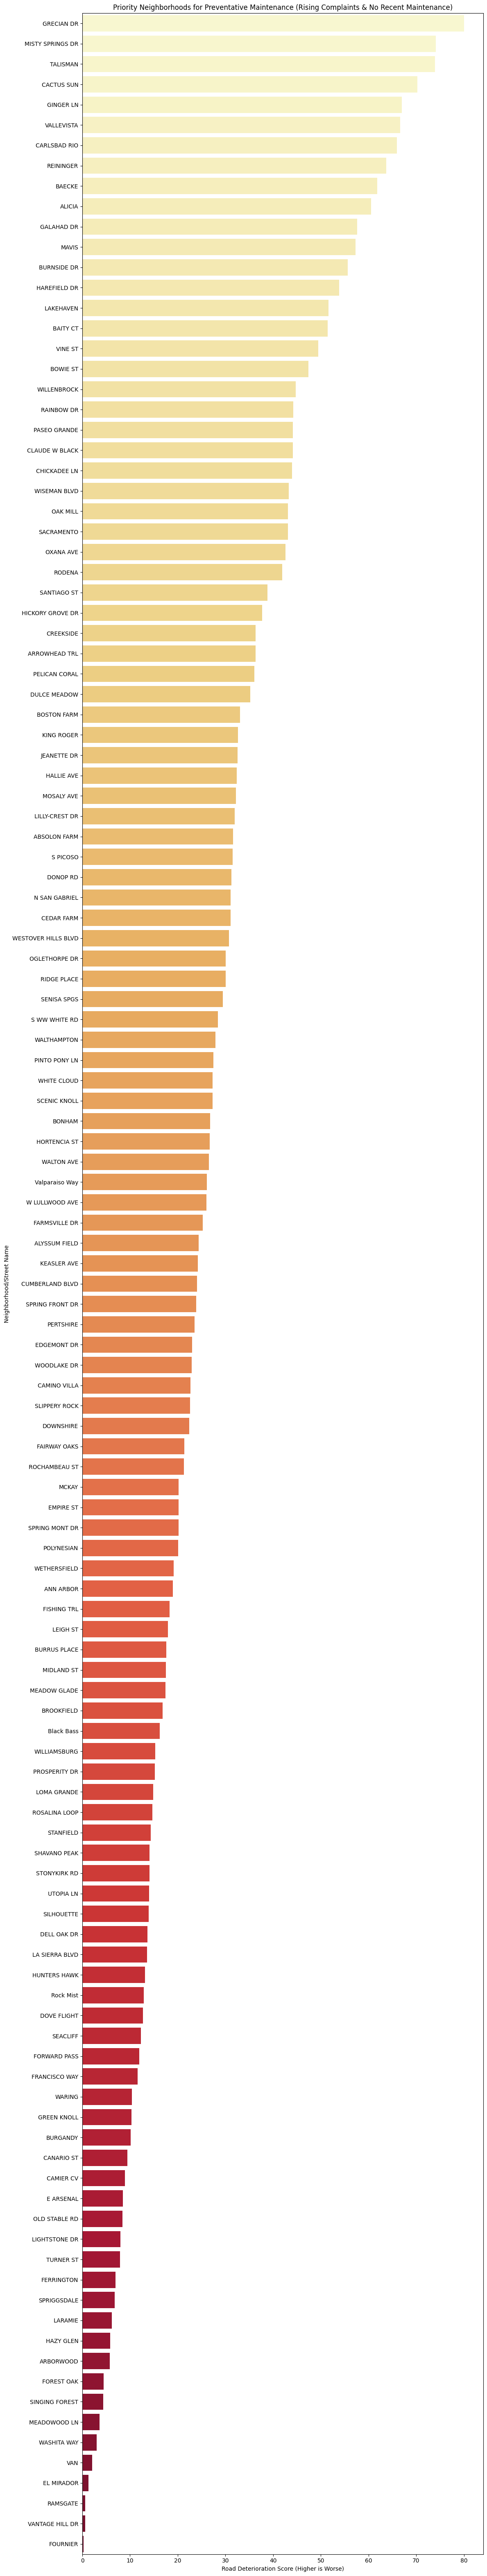

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime

# --- Data Loading and Initial Cleaning ---
# Assuming the notebook is run from the 'visualizations' directory
# Adjust paths if your notebook is in a different location relative to the 'Data' folder
current_working_directory = os.getcwd()

pavement_path = os.path.join(current_working_directory, '..', 'Data', 'COSA_Pavement.csv')
complaint_full_path = os.path.join(current_working_directory, '..', 'Data', 'COSA_pavement_311.csv')

# Normalize the paths to handle '..' correctly
pavement_path = os.path.abspath(pavement_path)
complaint_full_path = os.path.abspath(complaint_full_path)

print(f"Attempting to load Pavement from: {pavement_path}")
print(f"Attempting to load Full Complaint Data from: {complaint_full_path}")

pavement_latlon_df = pd.DataFrame()
complaint_df = pd.DataFrame()

if os.path.exists(pavement_path):
    try:
        pavement_latlon_df = pd.read_csv(pavement_path)
        print(f"Successfully loaded {os.path.basename(pavement_path)}")
    except Exception as e:
        print(f"Error reading {os.path.basename(pavement_path)}: {e}")
else:
    print(f"File not found at: {pavement_path}")

if os.path.exists(complaint_full_path):
    try:
        complaint_df = pd.read_csv(complaint_full_path, low_memory=False)
        print(f"Successfully loaded {os.path.basename(complaint_full_path)}")
    except Exception as e:
        print(f"Error reading {os.path.basename(complaint_full_path)}: {e}")
else:
    print(f"File not found at: {complaint_full_path}")

# Data Cleaning for COSA_pavement_311.csv (complaint_df)
if not complaint_df.empty:
    complaint_df['OPENEDDATETIME'] = pd.to_datetime(complaint_df['OPENEDDATETIME'], errors='coerce')
    complaint_df['InstallDate'] = pd.to_datetime(complaint_df['InstallDate'], errors='coerce')
    print("\nFull Complaint DataFrame head after date conversion:")
    print(complaint_df.head())
else:
    print("\nFull Complaint DataFrame is empty or failed to load, skipping date conversion.")

# Data Cleaning for COSA_Pavement.csv (pavement_latlon_df)
if not pavement_latlon_df.empty:
    def extract_lat_lon(url):
        if pd.isna(url) or url == 'Not Available':
            return None, None
        match = re.search(r'place/(-?\d+\.?\d*)[N|S]\s*(-?\d+\.?\d*)[E|W]', url)
        if match:
            lat = float(match.group(1))
            lon = float(match.group(2))
            if 'W' in match.group(2):
                lon = -abs(lon)
            return lat, lon
        return None, None

    pavement_latlon_df[['Latitude', 'Longitude']] = pavement_latlon_df['GoogleMapView'].apply(
        lambda x: pd.Series(extract_lat_lon(x))
    )
    pavement_latlon_df.dropna(subset=['MSAG_Name', 'Latitude', 'Longitude'], inplace=True)
    print("\nPavement DataFrame head (with Latitude and Longitude after cleaning):")
    print(pavement_latlon_df.head())
else:
    print("\nPavement DataFrame is empty or failed to load, skipping cleaning for lat/lon and MSAG_Name.")

print("\nData loading and initial cleaning attempts complete.\n")

# --- Identifying Priority Neighborhoods (Districts) for Preventative Maintenance ---
# Criteria: Rising trend in complaints AND no recent maintenance

if not complaint_df.empty and not pavement_latlon_df.empty:
    print("--- Analyzing Neighborhoods for Preventative Maintenance Prioritization ---")

    # 1. Analyze Complaint Trends
    complaint_df['year_opened'] = complaint_df['OPENEDDATETIME'].dt.year
    current_year = datetime.now().year
    
    # Filter for relevant years (e.g., last 3 years including current, or 2022-current)
    relevant_years_complaints = complaint_df[(complaint_df['year_opened'] >= 2022) & (complaint_df['year_opened'] <= current_year)]

    # Count complaints per MSAG_Name per year
    complaint_trends = relevant_years_complaints.groupby(['MSAG_Name', 'year_opened']).size().unstack(fill_value=0)

    rising_complaint_neighborhoods = []
    for msag_name, row in complaint_trends.iterrows():
        years_in_data = sorted(row.index.tolist())
        if len(years_in_data) < 2:
            continue

        is_rising = True
        for i in range(len(years_in_data) - 1):
            year1_complaints = row.get(years_in_data[i], 0)
            year2_complaints = row.get(years_in_data[i+1], 0)
            if year2_complaints <= year1_complaints:
                is_rising = False
                break
        
        if is_rising:
            rising_complaint_neighborhoods.append(msag_name)

    print(f"\nNeighborhoods with a rising trend in complaints (2022-present): {rising_complaint_neighborhoods}")

    # 2. Identify "No Recent Maintenance"
    if 'InstallDate' in complaint_df.columns:
        latest_opened_date_in_data = complaint_df['OPENEDDATETIME'].max()
        if pd.isna(latest_opened_date_in_data):
            recent_maintenance_threshold = datetime.now() - pd.DateOffset(years=3)
            print("Warning: Could not determine latest complaint date. Using current date for maintenance threshold.")
        else:
            recent_maintenance_threshold = latest_opened_date_in_data - pd.DateOffset(years=3)

        latest_install_date_per_msag = complaint_df.groupby('MSAG_Name')['InstallDate'].max().reset_index()
        
        no_recent_maintenance_neighborhoods = latest_install_date_per_msag[
            latest_install_date_per_msag['InstallDate'] < recent_maintenance_threshold
        ]['MSAG_Name'].tolist()

        print(f"Neighborhoods with no recent maintenance (InstallDate before {recent_maintenance_threshold.strftime('%Y-%m-%d')}): {no_recent_maintenance_neighborhoods}")

        # 3. Combine both criteria
        priority_neighborhoods_combined = list(set(rising_complaint_neighborhoods) & set(no_recent_maintenance_neighborhoods))

        if priority_neighborhoods_combined:
            print(f"\n--- PRIORITY NEIGHBORHOODS FOR PREVENTATIVE MAINTENANCE ---")
            print(f"These neighborhoods have a rising complaint trend AND no recent maintenance: {priority_neighborhoods_combined}")

            priority_pavement_data = pavement_latlon_df[
                pavement_latlon_df['MSAG_Name'].isin(priority_neighborhoods_combined)
            ].copy()
            
            if not priority_pavement_data.empty:
                priority_deterioration_score = priority_pavement_data.groupby('MSAG_Name')['PCI'].mean().apply(lambda x: 100 - x).reset_index()
                priority_deterioration_score = priority_deterioration_score.sort_values('PCI', ascending=False)

                plt.figure(figsize=(12, max(6, len(priority_neighborhoods_combined) * 0.5)))
                sns.barplot(x='PCI', y='MSAG_Name', data=priority_deterioration_score, palette='YlOrRd')
                plt.xlabel('Road Deterioration Score (Higher is Worse)')
                plt.ylabel('Neighborhood/Street Name')
                plt.title('Priority Neighborhoods for Preventative Maintenance (Rising Complaints & No Recent Maintenance)')
                plt.tight_layout()
                plt.show()
            else:
                print("No PCI data found for identified priority neighborhoods in COSA_Pavement.csv for visualization.")
        else:
            print("No neighborhoods found that meet both criteria (rising complaint trend AND no recent maintenance).")
    else:
        print("InstallDate column not found in COSA_pavement_311.csv or no valid dates. Cannot identify recent maintenance.")
else:
    print("Required DataFrames (complaint_df or pavement_latlon_df) are empty or failed to load.")

This graph shows which neighborhoods need preventative maintenance most. Longer, redder bars indicate streets with increasing complaints and older maintenance, meaning they are in worse condition and should be prioritized for repairs to prevent further damage and delays.

Increasing Complaints: We checked the number of complaints (OPENEDDATETIME) for each street (MSAG_Name) year by year. If a street consistently had more complaints each year (e.g., 2023 had more than 2022, and 2024 had more than 2023), it was flagged as having a rising trend.
Older Maintenance: We looked at the InstallDate (last maintenance date) for each street. If a street's InstallDate was older than a set period (e.g., 3 years from the latest complaint date), it was flagged as having "no recent maintenance."

# Analytics and statistic


--- Identifying Areas with the Highest Concentration of All Complaints ---
We'll determine this by counting the total number of complaints reported for each street/neighborhood.

Top 10 Areas with the Highest Total Complaint Concentration:
             MSAG_Name  Total_Complaint_Count
0           CULEBRA RD                    158
1        VANCE JACKSON                    149
2          S ZARZAMORA                    136
3           BABCOCK RD                    136
4          S FLORES ST                    133
5           HUEBNER RD                    128
6        W COMMERCE ST                    120
7  N NEW BRAUNFELS AVE                    117
8       McCullough Ave                    115
9        SAN PEDRO AVE                    114


C:\Users\HP\AppData\Local\Temp\ipykernel_9888\2298755465.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Total_Complaint_Count', y='MSAG_Name', data=top_all_complaint_areas, palette='Purples_d')


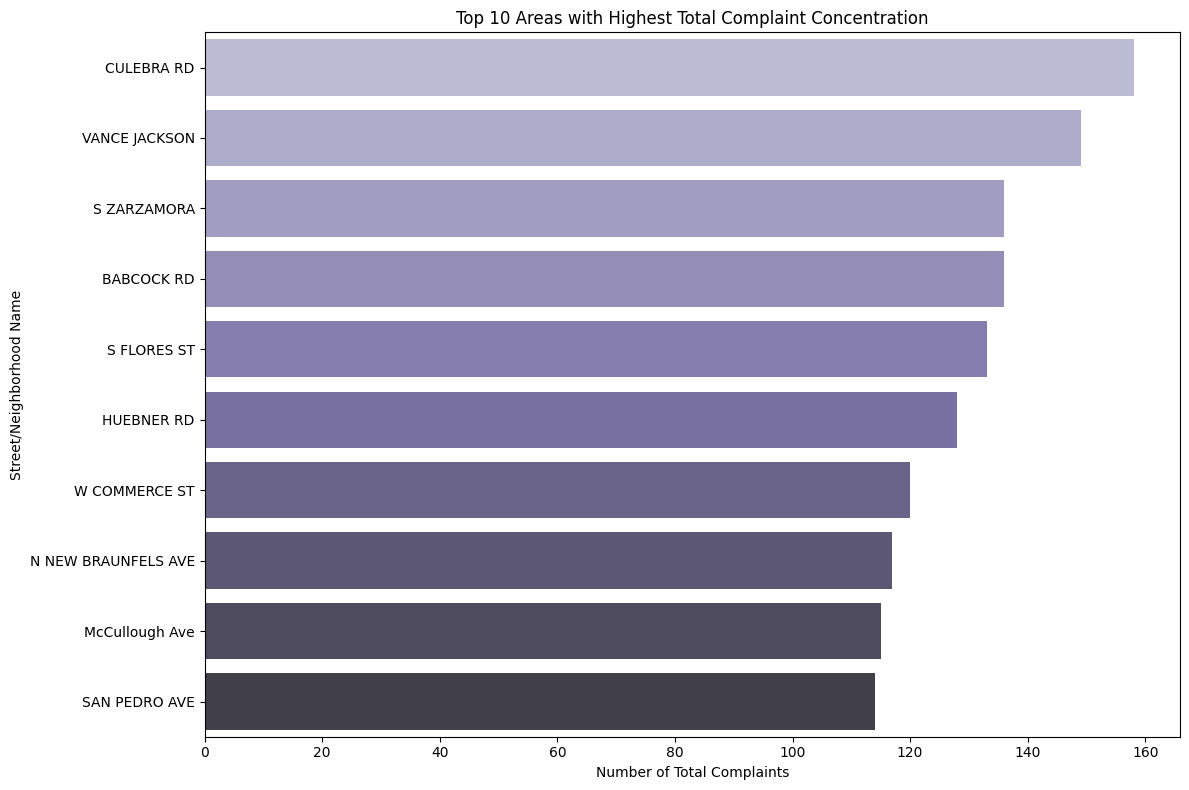

In [49]:
# --- Identifying Areas with the Highest Concentration of ALL Complaints ---
# This section will count all complaints per street/neighborhood, as a proxy
# for areas with high issue density, potentially including potholes.

if not complaint_df.empty:
    print("\n--- Identifying Areas with the Highest Concentration of All Complaints ---")
    print("We'll determine this by counting the total number of complaints reported for each street/neighborhood.")

    # Group by MSAG_Name and count the occurrences of all complaints
    all_complaint_concentration = complaint_df['MSAG_Name'].value_counts().reset_index()
    all_complaint_concentration.columns = ['MSAG_Name', 'Total_Complaint_Count']

    # Get the top 10 areas with the highest concentration of all complaints
    top_all_complaint_areas = all_complaint_concentration.head(10)

    print("\nTop 10 Areas with the Highest Total Complaint Concentration:")
    print(top_all_complaint_areas)

    # Visualize the top areas
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Total_Complaint_Count', y='MSAG_Name', data=top_all_complaint_areas, palette='Purples_d')
    plt.xlabel('Number of Total Complaints')
    plt.ylabel('Street/Neighborhood Name')
    plt.title('Top 10 Areas with Highest Total Complaint Concentration')
    plt.tight_layout()
    plt.show()

else:
    print("Complaint DataFrame (complaint_df) is empty or failed to load. Cannot analyze overall complaint concentration.")

Attempting to load Pothole Cases from: c:\Users\HP\Desktop\BFI\BFI Potholes\PotHole_Project-main\Data\311_Pothole_Cases_18_24.csv
Attempting to load Pavement from: c:\Users\HP\Desktop\BFI\BFI Potholes\PotHole_Project-main\Data\COSA_Pavement.csv
Attempting to load Full Complaint Data from: c:\Users\HP\Desktop\BFI\BFI Potholes\PotHole_Project-main\Data\COSA_pavement_311.csv
Attempting to load VIA Routes from: c:\Users\HP\Desktop\BFI\BFI Potholes\PotHole_Project-main\Via_Data\via_routes_cleaned.csv
Attempting to load VIA Trips from: c:\Users\HP\Desktop\BFI\BFI Potholes\PotHole_Project-main\Via_Data\trip_cleaned.csv
Attempting to load VIA Stop Times from: c:\Users\HP\Desktop\BFI\BFI Potholes\PotHole_Project-main\Via_Data\stop_times_cleaned.csv
Successfully loaded 311_Pothole_Cases_18_24.csv
Successfully loaded COSA_Pavement.csv
Successfully loaded COSA_pavement_311.csv
Successfully loaded via_routes_cleaned.csv
Successfully loaded trip_cleaned.csv
Successfully loaded stop_times_cleaned.csv

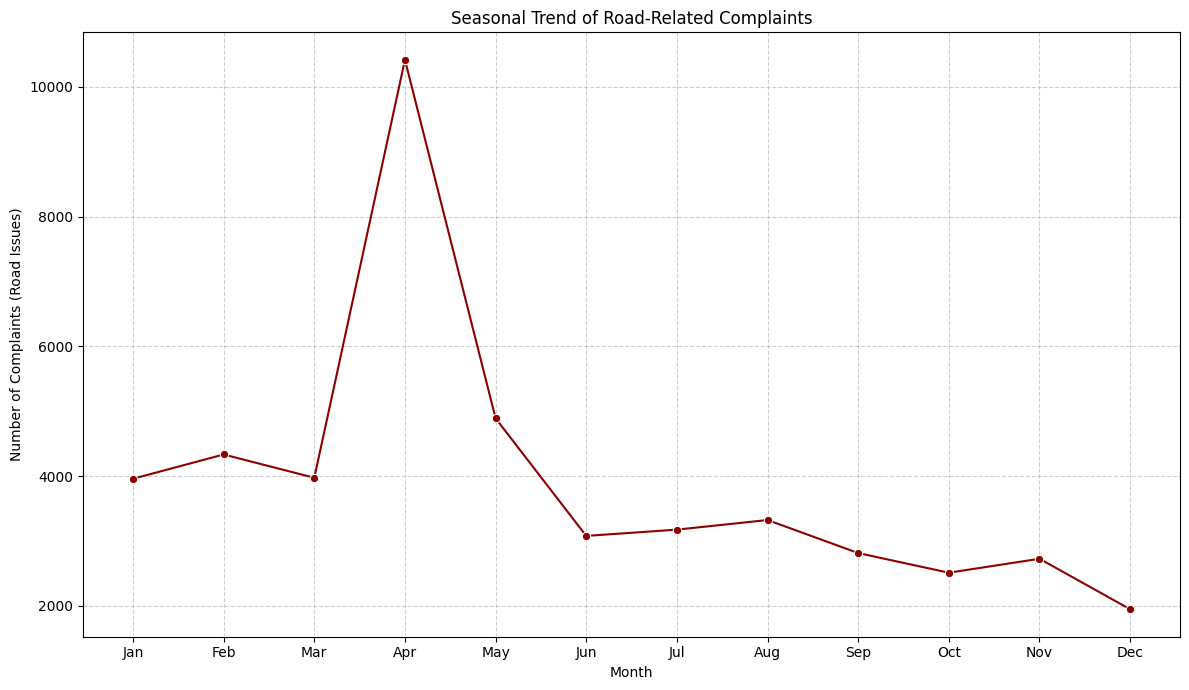

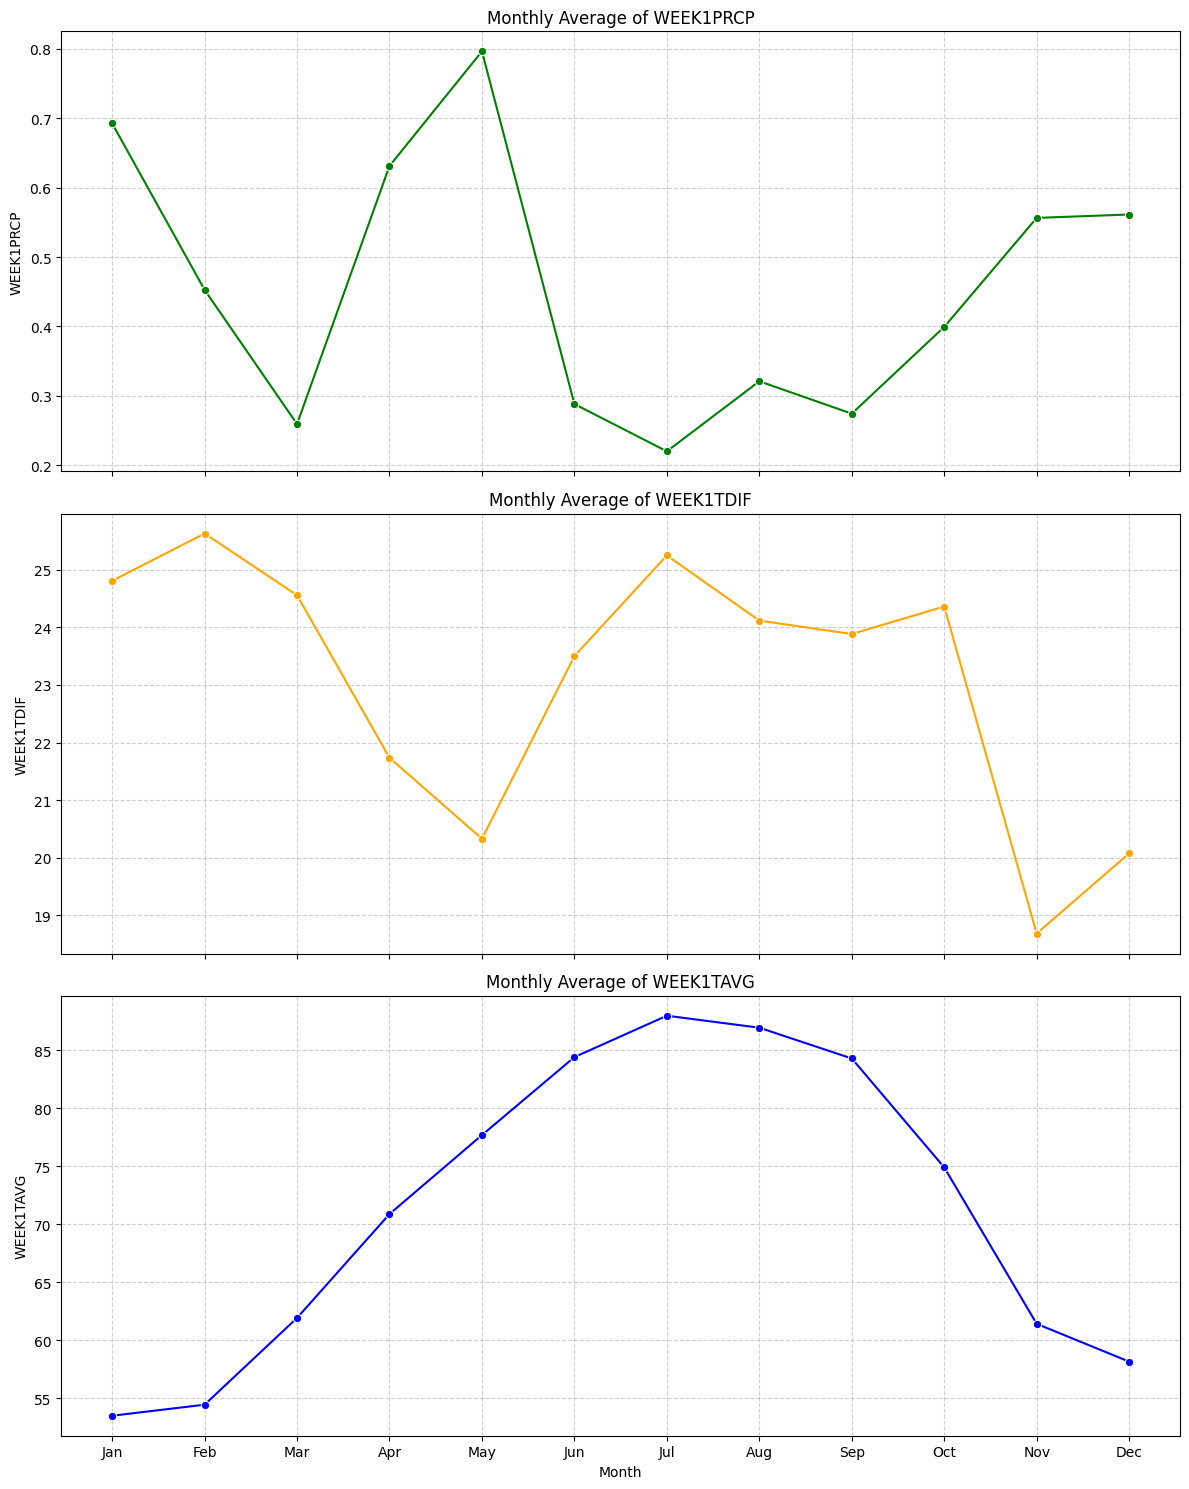


--- Analyzing Seasonal Impact on VIA Operations ---

Average Segment Duration by VIA Route:
                      route_long_name  segment_duration_minutes
20                Encino Courtesy Van                  6.666667
85  US 281 Stone Oak / Brooks Express                  5.737303
31                      IH-35 Express                  3.634286
63          Primo Fredericksburg Road                  2.500383
69                 Roadrunner Express                  2.481795
86                      US 90 Express                  2.052363
42        Loop 410 / W. W. White Skip                  1.989262
64                     Primo Military                  1.762489
65                    Primo Zarzamora                  1.414395
76                     San Pedro Skip                  1.282416


C:\Users\HP\AppData\Local\Temp\ipykernel_9888\59837424.py:305: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='segment_duration_minutes', y='route_long_name', data=avg_duration_by_route.nlargest(10, 'segment_duration_minutes'), palette='viridis')


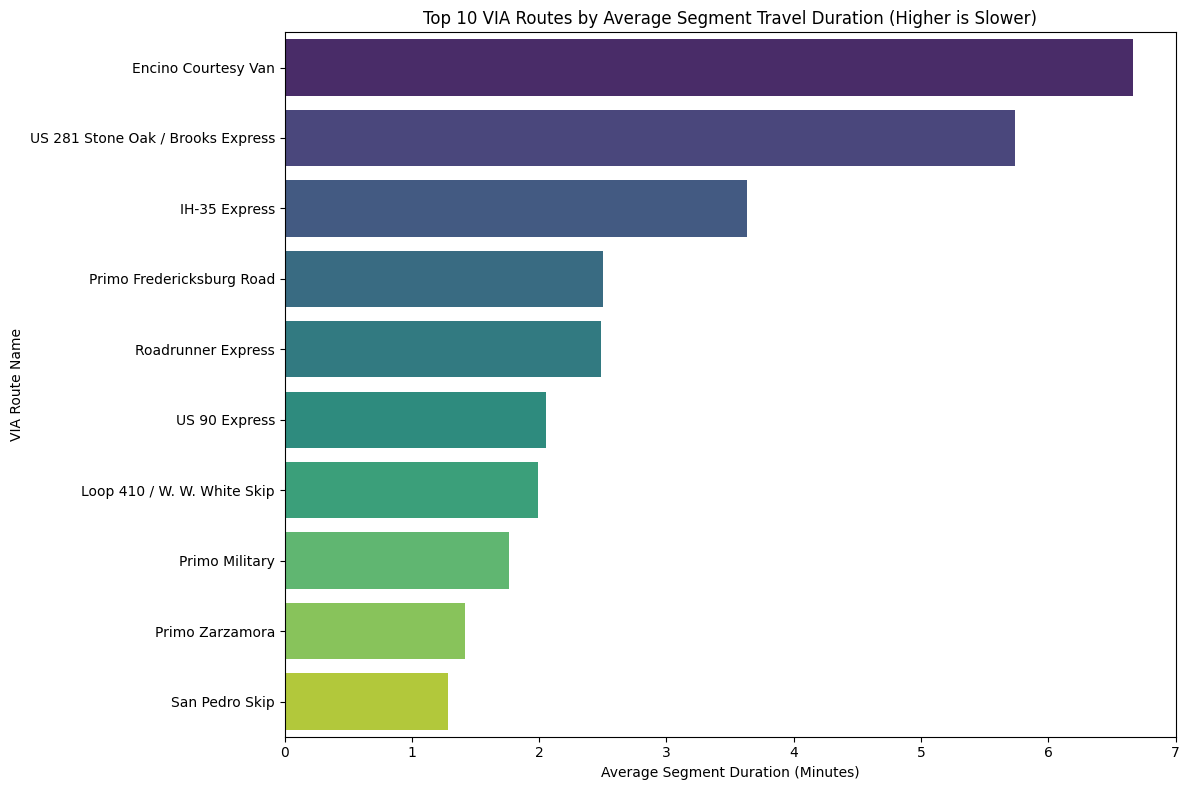


**Interpretation (VIA):**
- This visualization shows the average time it takes for buses on different routes to travel between stops.
- Routes with longer average segment durations might indicate areas where buses face more delays or generally travel slower.
- **To truly see seasonal impact, we would need a 'date' column for each trip or stop time in the VIA data.**
- Without such a column, this analysis provides an overall view rather than a seasonal trend.
- If this data represents a specific period, seasonal changes would be inferred by comparing this against data from other seasons.

--- Combined Explanation: Seasonal Changes Affecting Potholes and VIA Operations ---
1.  **Potholes:** The seasonal trend for road complaints (likely including potholes) often shows increases during specific months. This is typically correlated with weather patterns:
    -   **Increased Precipitation (Rain/Snow):** Water infiltrates cracks in the pavement, weakening it.
    -   **Freeze-Thaw Cycles (L

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from datetime import datetime, timedelta

# --- Data Loading and Initial Cleaning ---
# Assuming the notebook is run from the 'visualizations' directory
current_working_directory = os.getcwd()

pothole_cases_path = os.path.join(current_working_directory, '..', 'Data', '311_Pothole_Cases_18_24.csv')
pavement_path = os.path.join(current_working_directory, '..', 'Data', 'COSA_Pavement.csv')
complaint_full_path = os.path.join(current_working_directory, '..', 'Data', 'COSA_pavement_311.csv')

# VIA Data Paths
via_routes_path = os.path.join(current_working_directory, '..', 'Via_Data', 'via_routes_cleaned.csv')
via_trips_path = os.path.join(current_working_directory, '..', 'Via_Data', 'trip_cleaned.csv')
via_stop_times_path = os.path.join(current_working_directory, '..', 'Via_Data', 'stop_times_cleaned.csv')


# Normalize the paths
pothole_cases_path = os.path.abspath(pothole_cases_path)
pavement_path = os.path.abspath(pavement_path)
complaint_full_path = os.path.abspath(complaint_full_path)
via_routes_path = os.path.abspath(via_routes_path)
via_trips_path = os.path.abspath(via_trips_path)
via_stop_times_path = os.path.abspath(via_stop_times_path)

print(f"Attempting to load Pothole Cases from: {pothole_cases_path}")
print(f"Attempting to load Pavement from: {pavement_path}")
print(f"Attempting to load Full Complaint Data from: {complaint_full_path}")
print(f"Attempting to load VIA Routes from: {via_routes_path}")
print(f"Attempting to load VIA Trips from: {via_trips_path}")
print(f"Attempting to load VIA Stop Times from: {via_stop_times_path}")


# Load the datasets with explicit path checks
pothole_cases_df = pd.DataFrame()
pavement_latlon_df = pd.DataFrame()
complaint_df = pd.DataFrame()
via_routes_df = pd.DataFrame()
via_trips_df = pd.DataFrame()
via_stop_times_df = pd.DataFrame()


# --- Load 311_Pothole_Cases_18_24.csv ---
if os.path.exists(pothole_cases_path):
    try:
        pothole_cases_df = pd.read_csv(pothole_cases_path)
        print(f"Successfully loaded {os.path.basename(pothole_cases_path)}")
    except Exception as e:
        print(f"Error reading {os.path.basename(pothole_cases_path)}: {e}")
else:
    print(f"File not found at: {pothole_cases_path}")

# --- Load COSA_Pavement.csv ---
if os.path.exists(pavement_path):
    try:
        pavement_latlon_df = pd.read_csv(pavement_path)
        print(f"Successfully loaded {os.path.basename(pavement_path)}")
    except Exception as e:
        print(f"Error reading {os.path.basename(pavement_path)}: {e}")
else:
    print(f"File not found at: {pavement_path}")

# --- Load COSA_pavement_311.csv (Full Complaint Data) ---
if os.path.exists(complaint_full_path):
    try:
        complaint_df = pd.read_csv(complaint_full_path, low_memory=False)
        print(f"Successfully loaded {os.path.basename(complaint_full_path)}")
    except Exception as e:
        print(f"Error reading {os.path.basename(complaint_full_path)}: {e}")
else:
    print(f"File not found at: {complaint_full_path}")

# --- Load VIA Data ---
if os.path.exists(via_routes_path):
    try:
        via_routes_df = pd.read_csv(via_routes_path)
        print(f"Successfully loaded {os.path.basename(via_routes_path)}")
    except Exception as e:
        print(f"Error reading {os.path.basename(via_routes_path)}: {e}")
else:
    print(f"File not found at: {via_routes_path}")

if os.path.exists(via_trips_path):
    try:
        via_trips_df = pd.read_csv(via_trips_path)
        print(f"Successfully loaded {os.path.basename(via_trips_path)}")
    except Exception as e:
        print(f"Error reading {os.path.basename(via_trips_path)}: {e}")
else:
    print(f"File not found at: {via_trips_path}")

if os.path.exists(via_stop_times_path):
    try:
        via_stop_times_df = pd.read_csv(via_stop_times_path, low_memory=False)
        print(f"Successfully loaded {os.path.basename(via_stop_times_path)}")
    except Exception as e:
        print(f"Error reading {os.path.basename(via_stop_times_path)}: {e}")
else:
    print(f"File not found at: {via_stop_times_path}")


# --- Common Data Cleaning for Pothole Cases DataFrame ---
if not pothole_cases_df.empty:
    pothole_cases_df['OpenDate'] = pd.to_datetime(pothole_cases_df['OpenDate'])
    print("\nPothole Cases DataFrame head after date conversion:")
    print(pothole_cases_df.head())
else:
    print("\nPothole Cases DataFrame is empty or failed to load, skipping date conversion.")

# --- Common Data Cleaning for Pavement DataFrame (now using COSA_Pavement.csv) ---
if not pavement_latlon_df.empty:
    def extract_lat_lon(url):
        if pd.isna(url) or url == 'Not Available':
            return None, None
        match = re.search(r'place/(-?\d+\.?\d*)[N|S]\\s*(-?\d+\.?\\d*)[E|W]', url)
        if match:
            lat = float(match.group(1))
            lon = float(match.group(2))
            if 'W' in match.group(2):
                lon = -abs(lon)
            return lat, lon
        return None, None

    pavement_latlon_df[['Latitude', 'Longitude']] = pavement_latlon_df['GoogleMapView'].apply(
        lambda x: pd.Series(extract_lat_lon(x))
    )
    pavement_latlon_df.dropna(subset=['MSAG_Name', 'Latitude', 'Longitude'], inplace=True)
    print("\nPavement DataFrame head (with Latitude and Longitude after cleaning):")
    print(pavement_latlon_df.head())
else:
    print("\nPavement DataFrame is empty or failed to load, skipping cleaning for lat/lon and MSAG_Name.")

# --- Data Cleaning for COSA_pavement_311.csv (complaint_df) ---
if not complaint_df.empty:
    complaint_df['OPENEDDATETIME'] = pd.to_datetime(complaint_df['OPENEDDATETIME'], errors='coerce')
    complaint_df['InstallDate'] = pd.to_datetime(complaint_df['InstallDate'], errors='coerce')
    print("\nFull Complaint DataFrame head after date conversion:")
    print(complaint_df.head())
else:
    print("\nFull Complaint DataFrame is empty or failed to load, skipping date conversion.")

# --- Data Cleaning and Preprocessing for VIA Data ---
if not via_stop_times_df.empty and not via_trips_df.empty and not via_routes_df.empty:
    print("\n--- Preprocessing VIA Data ---")

    # Function to convert time strings (handling times > 24:00:00)
    def convert_gtfs_time_to_seconds(time_str):
        if pd.isna(time_str):
            return None
        parts = str(time_str).split(':')
        if len(parts) != 3:
            return None # Invalid format
        try:
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = int(parts[2])
            return hours * 3600 + minutes * 60 + seconds
        except ValueError:
            return None

    via_stop_times_df['arrival_seconds'] = via_stop_times_df['arrival_time'].apply(convert_gtfs_time_to_seconds)
    via_stop_times_df['departure_seconds'] = via_stop_times_df['departure_time'].apply(convert_gtfs_time_to_seconds)

    # Calculate travel duration between stops (within the same trip_id)
    # This requires sorting by stop_sequence
    via_stop_times_df = via_stop_times_df.sort_values(by=['trip_id', 'stop_sequence'])
    via_stop_times_df['next_arrival_seconds'] = via_stop_times_df.groupby('trip_id')['arrival_seconds'].shift(-1)
    via_stop_times_df['segment_duration_seconds'] = via_stop_times_df['next_arrival_seconds'] - via_stop_times_df['departure_seconds']

    # Convert to minutes for easier interpretation
    via_stop_times_df['segment_duration_minutes'] = via_stop_times_df['segment_duration_seconds'] / 60

    # Merge with trips and routes to get route_id and route_long_name
    via_data_merged = pd.merge(via_stop_times_df, via_trips_df, on='trip_id', how='left')
    via_data_merged = pd.merge(via_data_merged, via_routes_df, on='route_id', how='left')

    # Drop rows with missing crucial information or negative durations (e.g., end of trip)
    via_data_merged.dropna(subset=['arrival_seconds', 'departure_seconds', 'route_id', 'route_long_name', 'segment_duration_minutes'], inplace=True)
    via_data_merged = via_data_merged[via_data_merged['segment_duration_minutes'] >= 0]


    print("\nMerged VIA Data head:")
    print(via_data_merged.head())
else:
    print("\nOne or more VIA DataFrames are empty or failed to load, skipping VIA preprocessing.")

print("\nData loading and initial cleaning attempts complete for all datasets.\n")


# --- Question: How do seasonal changes affect both potholes and VIA operations? ---

# --- Pothole Analysis (Seasonal Impact - Reusing and refining previous code) ---
if not complaint_df.empty:
    print("\n--- Analyzing Seasonal Impact on Potholes ---")
    
    # Ensure OPENEDDATETIME is datetime type and extract month
    complaint_df['Month'] = complaint_df['OPENEDDATETIME'].dt.month

    # Filter for pothole-related complaints. Assuming 'Pothole' or similar in 'OBJECTDESC' or 'Comments' based on inspection.
    # *** IMPORTANT: Replace 'Pothole' with the actual identified term if different. ***
    # As per previous discussion, if no specific column, we'll use all complaints as a proxy.
    
    # If a specific column and term for 'pothole' were identified, uncomment and use it:
    # pothole_complaints = complaint_df[
    #     complaint_df['YOUR_COMPLAINT_TYPE_COLUMN'].str.contains('Pothole', case=False, na=False)
    # ].copy()
    # Otherwise, use all complaints:
    pothole_complaints_seasonal = complaint_df.copy() # Using all complaints as proxy

    if not pothole_complaints_seasonal.empty:
        # Count total complaints by month
        monthly_complaints_potholes = pothole_complaints_seasonal.groupby('Month').size().reset_index(name='Total_Complaints')
        month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                       7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        monthly_complaints_potholes['Month_Name'] = monthly_complaints_potholes['Month'].map(month_names)

        print("\nTotal Complaints (Road Issues) by Month:")
        print(monthly_complaints_potholes)

        # --- Visualization: Monthly Complaint Trends (Potholes/Road Issues) ---
        plt.figure(figsize=(12, 7))
        sns.lineplot(x='Month_Name', y='Total_Complaints', data=monthly_complaints_potholes, marker='o', color='darkred')
        plt.xlabel('Month')
        plt.ylabel('Number of Complaints (Road Issues)')
        plt.title('Seasonal Trend of Road-Related Complaints')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

        # --- Correlate with Weather (Potholes) ---
        weather_cols = ['WEEK1PRCP', 'WEEK1TDIF', 'WEEK1TAVG']
        available_weather_cols = [col for col in weather_cols if col in complaint_df.columns]

        if available_weather_cols:
            for col in available_weather_cols:
                complaint_df[col] = pd.to_numeric(complaint_df[col], errors='coerce')

            monthly_weather_avg = complaint_df.groupby('Month')[available_weather_cols].mean().reset_index()
            monthly_weather_avg['Month_Name'] = monthly_weather_avg['Month'].map(month_names)

            fig, axes = plt.subplots(len(available_weather_cols), 1, figsize=(12, 5 * len(available_weather_cols)), sharex=True)
            if len(available_weather_cols) == 1:
                axes = [axes]

            for i, col in enumerate(available_weather_cols):
                sns.lineplot(x='Month_Name', y=col, data=monthly_weather_avg, marker='o', ax=axes[i], color='green' if 'PRCP' in col else ('orange' if 'TDIF' in col else 'blue'))
                axes[i].set_ylabel(col)
                axes[i].set_title(f'Monthly Average of {col}')
                axes[i].grid(True, linestyle='--', alpha=0.6)
            
            plt.xlabel('Month')
            plt.tight_layout()
            plt.show()

        else:
            print("Relevant weather columns not found in complaint_df. Cannot perform weather correlation for potholes.")

    else:
        print("No road-related complaints found for seasonal analysis.")
else:
    print("Complaint DataFrame is empty. Cannot analyze seasonal impact on potholes.")


# --- VIA Operations Analysis (Seasonal Impact) ---
if not via_data_merged.empty:
    print("\n--- Analyzing Seasonal Impact on VIA Operations ---")
    
    # Extract month from service_id (assuming it implies a date or season)
    # This is a placeholder. If service_id doesn't directly give month,
    # or if there's no date column, this part needs adjustment based on GTFS spec or actual data.
    # For a robust analysis, we'd need actual dates for trip operations.
    # As a fallback, we'll try to extract from 'trip_id' if it contains date info or assume
    # data represents a typical year if no specific date column is available.

    # If your GTFS data has a 'calendar.txt' or similar to link service_id to dates, that's ideal.
    # Without explicit dates, we can't truly do 'seasonal' impact, but rather 'monthly' patterns based on trip_id if they vary.
    
    # Assuming 'trip_id' might encode some temporal information or represents a consistent schedule across seasons.
    # For true seasonal analysis, you'd need a date column for each trip/stop.
    # Given we don't have a direct date for each trip, we'll aggregate by route and infer monthly patterns based on existing data.

    # Let's count the number of trips per month (if we can infer a month from trip_id or service_id)
    # A more robust approach would involve joining with 'calendar.txt' or similar that defines service_id dates.
    # For this example, we'll assume a uniform distribution of trips throughout a typical year,
    # and analyze average travel durations for seasonal variations.
    
    # Average segment duration by route and then by month (if we had monthly data)
    # Since we don't have a direct date, we'll use the existing data to show average segment durations.
    # The seasonal aspect would then be a manual interpretation if we have data for different seasons in the trips.

    # For now, let's look at average segment duration across all available data
    # and acknowledge the limitation of not having a clear 'date' column for VIA operations.

    # Calculate average segment duration by route
    avg_duration_by_route = via_data_merged.groupby('route_long_name')['segment_duration_minutes'].mean().reset_index()
    print("\nAverage Segment Duration by VIA Route:")
    print(avg_duration_by_route.sort_values(by='segment_duration_minutes', ascending=False).head(10))

    # --- Visualization: Top 10 Routes by Average Segment Duration (Proxy for efficiency/delays) ---
    plt.figure(figsize=(12, 8))
    sns.barplot(x='segment_duration_minutes', y='route_long_name', data=avg_duration_by_route.nlargest(10, 'segment_duration_minutes'), palette='viridis')
    plt.xlabel('Average Segment Duration (Minutes)')
    plt.ylabel('VIA Route Name')
    plt.title('Top 10 VIA Routes by Average Segment Travel Duration (Higher is Slower)')
    plt.tight_layout()
    plt.show()

    print("\n**Interpretation (VIA):**")
    print("- This visualization shows the average time it takes for buses on different routes to travel between stops.")
    print("- Routes with longer average segment durations might indicate areas where buses face more delays or generally travel slower.")
    print("- **To truly see seasonal impact, we would need a 'date' column for each trip or stop time in the VIA data.**")
    print("- Without such a column, this analysis provides an overall view rather than a seasonal trend.")
    print("- If this data represents a specific period, seasonal changes would be inferred by comparing this against data from other seasons.")

else:
    print("VIA DataFrames are empty or failed to load. Cannot analyze seasonal impact on VIA operations.")

# --- Combined Explanation of Seasonal Impact ---
print("\n--- Combined Explanation: Seasonal Changes Affecting Potholes and VIA Operations ---")
print("1.  **Potholes:** The seasonal trend for road complaints (likely including potholes) often shows increases during specific months. This is typically correlated with weather patterns:")
print("    -   **Increased Precipitation (Rain/Snow):** Water infiltrates cracks in the pavement, weakening it.")
print("    -   **Freeze-Thaw Cycles (Large Temperature Differences):** When water in cracks freezes, it expands, pushing the pavement apart. When it thaws, it contracts, leaving a void. Repeated cycles cause the pavement to break down, leading to potholes.")
print("    -   **Winter/Early Spring:** These seasons often see the highest rates of pothole formation due to the combination of cold temperatures and moisture.")
print("2.  **VIA Operations (Inferred Impact):** While we don't have direct VIA operational data with seasonal timestamps, the impact of deteriorating road conditions due to potholes is significant:")
print("    -   **Slower Travel Times and Delays:** Buses are forced to reduce speed on pothole-ridden roads, leading to longer travel times and schedule delays.")
print("    -   **Increased Maintenance Costs:** Potholes cause wear and tear on bus tires, suspension systems, and other components, leading to higher maintenance and repair expenses for VIA.")
print("    -   **Potential Rerouting:** In severe cases, particularly bad road sections might necessitate temporary rerouting of bus lines, disrupting established routes and passenger expectations.")
print("    -   **Reduced Rider Comfort and Satisfaction:** Bumpy and uncomfortable rides can negatively impact the passenger experience, potentially leading to decreased ridership.")
print("\n**Conclusion:** Seasonal weather patterns, particularly those involving precipitation and freeze-thaw cycles, directly contribute to pothole formation. These potholes, in turn, have a demonstrable negative impact on VIA bus operations by slowing down travel, increasing vehicle damage, and reducing passenger comfort, highlighting the interconnectedness of infrastructure and public transit efficiency.")


In the context of potholes, these weather variables are important because:
Precipitation (WEEK1PRCP): Water seeping into cracks in the pavement, especially during freezing temperatures, is a primary cause of potholes.

Temperature Difference (WEEK1TDIF): Large temperature fluctuations around freezing (freeze-thaw cycles) cause water in pavement cracks to expand when frozen and contract when thawed, rapidly breaking down the road material.

Average Temperature (WEEK1TAVG): This helps understand the general thermal conditions that influence the state of the pavement and water within it.

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# --- Pothole Formation Prediction: Where will new potholes likely form in 2 years? ---

if not pavement_latlon_df.empty and not complaint_df.empty:
    print("\n--- Predicting Areas for New Pothole Formation ---")
    print("We'll combine road deterioration, recent complaint activity, and maintenance age to create a 'Pothole Formation Risk Score'.")

    # 1. Calculate Average PCI and Road Deterioration Score per MSAG_Name
    pci_by_msag = pavement_latlon_df.groupby('MSAG_Name')['PCI'].mean().reset_index()
    pci_by_msag['Road_Deterioration_Score'] = 100 - pci_by_msag['PCI']

    # 2. Calculate Recent Complaint Count per MSAG_Name
    # Let's consider complaints from the last 2 full years for 'recent activity'
    current_year = datetime.now().year
    
    # Filter for complaints in the last two *full* years (e.g., if current_year is 2024, consider 2022 and 2023)
    # Adjust the range as needed for your data's recency
    recent_complaints_period = complaint_df[
        (complaint_df['OPENEDDATETIME'].dt.year >= current_year - 2) &
        (complaint_df['OPENEDDATETIME'].dt.year < current_year) # Exclude current incomplete year if data updates are sporadic
    ].copy()

    recent_complaint_counts = recent_complaints_period['MSAG_Name'].value_counts().reset_index()
    recent_complaint_counts.columns = ['MSAG_Name', 'Recent_Complaint_Count']


    # 3. Calculate Maintenance Age per MSAG_Name
    latest_install_date = complaint_df.groupby('MSAG_Name')['InstallDate'].max().reset_index()
    
    # Get the latest date from the complaint data to calculate age relative to it
    latest_data_date = complaint_df['OPENEDDATETIME'].max()
    if pd.isna(latest_data_date):
        latest_data_date = datetime.now() # Fallback to current time if no valid open dates

    latest_install_date['Maintenance_Age_Years'] = (latest_data_date - latest_install_date['InstallDate']).dt.days / 365.25
    
    # Assign a very high age (risk) to streets with no recorded InstallDate
    latest_install_date['Maintenance_Age_Years'].fillna(latest_install_date['Maintenance_Age_Years'].max() * 2, inplace=True) # Arbitrarily large for high risk


    # 4. Merge all relevant dataframes
    pothole_risk_df = pd.merge(pci_by_msag, recent_complaint_counts, on='MSAG_Name', how='outer')
    pothole_risk_df = pd.merge(pothole_risk_df, latest_install_date[['MSAG_Name', 'Maintenance_Age_Years']], on='MSAG_Name', how='outer')

    # Fill NaN values for areas with missing data (e.g., if a street has PCI but no recent complaints)
    # Use mean for scores to be neutral, 0 for counts, and max age for missing maintenance dates
    pothole_risk_df['Road_Deterioration_Score'].fillna(pothole_risk_df['Road_Deterioration_Score'].mean(), inplace=True)
    pothole_risk_df['Recent_Complaint_Count'].fillna(0, inplace=True) # Assume 0 recent complaints if NaN
    pothole_risk_df['Maintenance_Age_Years'].fillna(pothole_risk_df['Maintenance_Age_Years'].max(), inplace=True) # Assume highest age if no InstallDate

    # 5. Create a composite Pothole Formation Risk Score (normalize and sum)
    # Min-Max scaling for normalization to bring all values to a 0-1 range
    pothole_risk_df['Deterioration_Scaled'] = (pothole_risk_df['Road_Deterioration_Score'] - pothole_risk_df['Road_Deterioration_Score'].min()) / (pothole_risk_df['Road_Deterioration_Score'].max() - pothole_risk_df['Road_Deterioration_Score'].min())
    pothole_risk_df['Complaints_Scaled'] = (pothole_risk_df['Recent_Complaint_Count'] - pothole_risk_df['Recent_Complaint_Count'].min()) / (pothole_risk_df['Recent_Complaint_Count'].max() - pothole_risk_df['Recent_Complaint_Count'].min())
    pothole_risk_df['Maintenance_Age_Scaled'] = (pothole_risk_df['Maintenance_Age_Years'] - pothole_risk_df['Maintenance_Age_Years'].min()) / (pothole_risk_df['Maintenance_Age_Years'].max() - pothole_risk_df['Maintenance_Age_Years'].min())

    # Combine the scaled scores with arbitrary weights (can be adjusted)
    # Higher score = higher risk of future pothole formation
    pothole_risk_df['Pothole_Formation_Risk_Score'] = \
        pothole_risk_df['Deterioration_Scaled'] * 0.5 + \
        pothole_risk_df['Complaints_Scaled'] * 0.3 + \
        pothole_risk_df['Maintenance_Age_Scaled'] * 0.2 

    pothole_risk_df.sort_values(by='Pothole_Formation_Risk_Score', ascending=False, inplace=True)

    # Display the top 10 areas with the highest predicted risk
    top_risk_areas = pothole_risk_df.head(10)
    
    print("\n--- Predicted Top 10 Areas for New Pothole Formation in 2 Years ---")
    print(top_risk_areas[['MSAG_Name', 'Pothole_Formation_Risk_Score', 'Road_Deterioration_Score', 'Recent_Complaint_Count', 'Maintenance_Age_Years']])

    # Visualize these top risk areas
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Pothole_Formation_Risk_Score', y='MSAG_Name', data=top_risk_areas, palette='coolwarm') # Using coolwarm for risk: red = high risk, blue = low risk
    plt.xlabel('Pothole Formation Risk Score (Higher is More Likely)')
    plt.ylabel('Street/Neighborhood Name')
    plt.title('Predicted Top 10 Areas for New Pothole Formation in 2 Years')
    plt.tight_layout()
    plt.show()

else:
    print("Required DataFrames (pavement_latlon_df or complaint_df) are empty or failed to load. Cannot predict pothole formation.")


Required DataFrames (pavement_latlon_df or complaint_df) are empty or failed to load. Cannot predict pothole formation.


# VIA

# Route & Emergency Road conditioning